Data on confirmed COVID-19 cases in Scotland by Health board taken from the Web Archive [WayBackMachine](https://web.archive.org/web/*/https://www. gov.scot/coronavirus-covid-19/) capture of the Scottish Government published health board data published since 2020-03-05 ( broken down by specific health boards ).

In [1]:
pip install descartes html2text geopandas lxml matplotlib pandas tabulate word2number xarray 

Note: you may need to restart the kernel to use updated packages.


In [328]:
from datetime import datetime
import os

from tabulate import tabulate
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import ScotlandCOVID19

In [4]:
yesterday = int(str(datetime.now())[:10].replace('-',''))-1

In [14]:
results = []
for date in range(20200306, yesterday+1):
    results.append(ScotlandCOVID19.ScotlandCOVID19.from_date(str(date)))

20200306
 6 March 2020
20200307
 7 March 2020
20200308
 8 March 2020
20200309
 9 March 2020
20200310
10 March 2020
20200311
11 March 2020
20200312
12 March 2020
20200313
13 March 2020
20200314
14 March 2020
20200315
15 March 2020
20200316
16 March 2020
20200317
17 March 2020
20200318
18 March 2020
20200319
19 March 2020
20200320
20 March 2020
20200321
21 March 2020
20200322
22 March 2020
20200323
23 March 2020


In [15]:
results.append(ScotlandCOVID19.ScotlandCOVID19.from_latest_government())

Latest
24 March 2020


In [ ]:
results.append(ScotlandCOVID19.ScotlandCOVID19.from_latest_government())

In [16]:
all_results = ScotlandCOVID19.ScotlandCOVID19Results(results)

In [17]:
all_results.to_netcdf()

In [18]:
all_results.counts

Health board,Ayrshire and Arran,Borders,Dumfries and Galloway,Fife,Forth Valley,Grampian,Greater Glasgow and Clyde,Highland,Lanarkshire,Lothian,Shetland,Tayside
date,,,,,,,,,,,,
2020-03-06,1,0,0,2,2,3,1,0,0,1,0,1
2020-03-07,1,0,0,2,2,4,2,0,2,2,0,1
2020-03-08,1,0,0,2,2,4,3,0,2,3,0,1
2020-03-09,1,0,0,2,2,4,3,0,3,5,2,1
2020-03-10,1,0,0,2,2,6,3,0,3,7,2,1
2020-03-11,3,2,0,2,2,6,5,0,4,8,2,2
2020-03-12,4,2,0,3,6,7,10,0,7,11,6,4
2020-03-13,4,3,0,4,6,11,21,0,7,20,6,3
2020-03-14,6,5,0,6,6,9,31,1,10,25,11,11


In [19]:
all_results.counts.diff().iloc[-1].sum()

85.0

In [20]:
all_results.tests.diff()

date
2020-03-06      NaN
2020-03-07    155.0
2020-03-08    277.0
2020-03-09    144.0
2020-03-10    133.0
2020-03-11     82.0
2020-03-12    576.0
2020-03-13    422.0
2020-03-14    401.0
2020-03-15    525.0
2020-03-16    655.0
2020-03-17    351.0
2020-03-18    845.0
2020-03-19    681.0
2020-03-20    778.0
2020-03-21    709.0
2020-03-22    420.0
2020-03-23    685.0
2020-03-24    604.0
Name: Tests concluded, dtype: float64

In [21]:
all_results.counts.iloc[-2] - all_results.counts.iloc[-3].transpose()

Health board
Ayrshire and Arran            9
Borders                       1
Dumfries and Galloway         2
Fife                          3
Forth Valley                 10
Grampian                      1
Greater Glasgow and Clyde    22
Highland                      4
Lanarkshire                   9
Lothian                      13
Shetland                      0
Tayside                       9
dtype: int64

In [22]:
(all_results.counts.iloc[-1] - all_results.counts.iloc[-2]).sum()

85

In [24]:
count_difference = all_results.counts.diff()

In [25]:
count_difference.to_csv('data/daily_difference_in_counts.csv')

In [26]:
count_difference

Health board,Ayrshire and Arran,Borders,Dumfries and Galloway,Fife,Forth Valley,Grampian,Greater Glasgow and Clyde,Highland,Lanarkshire,Lothian,Shetland,Tayside
date,,,,,,,,,,,,
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0
2020-03-10,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-11,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
2020-03-12,1.0,0.0,0.0,1.0,4.0,1.0,5.0,0.0,3.0,3.0,4.0,2.0
2020-03-13,0.0,1.0,0.0,1.0,0.0,4.0,11.0,0.0,0.0,9.0,0.0,-1.0
2020-03-14,2.0,2.0,0.0,2.0,0.0,-2.0,10.0,1.0,3.0,5.0,5.0,8.0


In [27]:
all_results.counts.to_csv('data/daily_counts_by_health_board.csv')

In [28]:
print("Daily increase in number of test concluded")
daily_increase_in_tests_concluded = all_results.tests.diff()[1:].astype('int')
print(daily_increase_in_tests_concluded)
daily_increase_in_tests_concluded.to_csv('data/daily_increase_in_tests_concluded.csv')

Daily increase in number of test concluded
date
2020-03-07    155
2020-03-08    277
2020-03-09    144
2020-03-10    133
2020-03-11     82
2020-03-12    576
2020-03-13    422
2020-03-14    401
2020-03-15    525
2020-03-16    655
2020-03-17    351
2020-03-18    845
2020-03-19    681
2020-03-20    778
2020-03-21    709
2020-03-22    420
2020-03-23    685
2020-03-24    604
Name: Tests concluded, dtype: int64


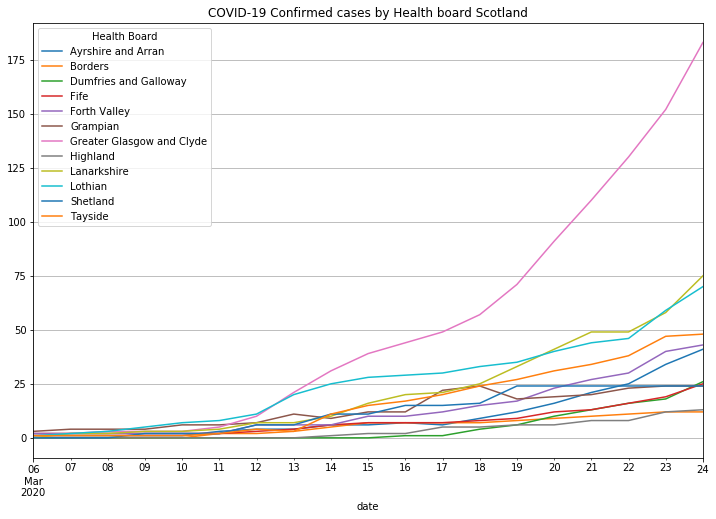

In [103]:
all_results.counts.plot(figsize=(12,8), title='COVID-19 Confirmed cases by Health board Scotland', grid=True)
plt.savefig('output/confirmed_cases_by_health_board_time_series.png')

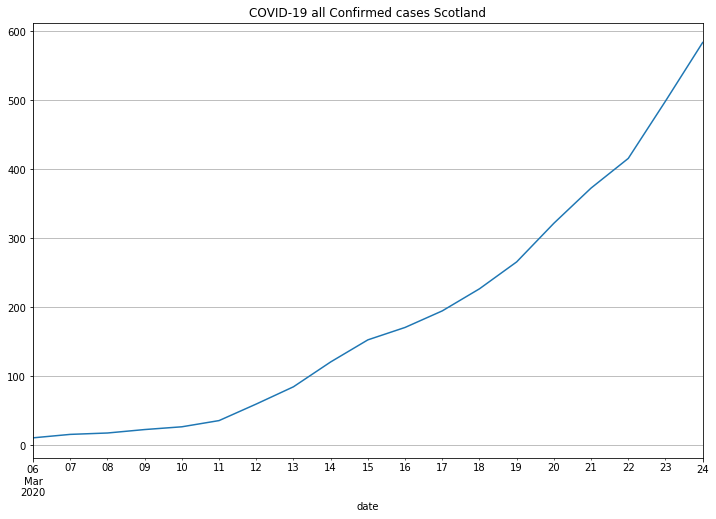

In [104]:
all_results.counts.sum(axis=1).plot(figsize=(12,8), title='COVID-19 all Confirmed cases Scotland', grid=True)
plt.savefig('output/all_confirmed_cases_time_series.png')

In [30]:
print("Daily increase of cases")
daily_increase_confirmed_cases = all_results.counts.sum(axis=1).diff()
daily_increase_confirmed_cases.to_csv('data/daily_increase_confirmed_cases.csv')

Daily increase of cases


In [31]:
print("Percentage of positive test daily")
percentage_of_positive_cases_daily = (all_results.counts.sum(axis=1).diff()/all_results.tests.diff() * 100)
percentage_of_positive_cases_daily.to_csv('data/percentage_of_positive_cases_daily')
print(percentage_of_positive_cases_daily)

Percentage of positive test daily
date
2020-03-06          NaN
2020-03-07     3.225806
2020-03-08     0.722022
2020-03-09     3.472222
2020-03-10     3.007519
2020-03-11    10.975610
2020-03-12     4.166667
2020-03-13     5.924171
2020-03-14     8.977556
2020-03-15     6.095238
2020-03-16     2.748092
2020-03-17     6.837607
2020-03-18     3.786982
2020-03-19     5.726872
2020-03-20     7.197943
2020-03-21     7.193230
2020-03-22    10.238095
2020-03-23    12.116788
2020-03-24    14.072848
dtype: float64


In [32]:
print("% increase cases across Scotland")
percentage_increase_cases_daily = round(all_results.counts.sum(axis=1).diff()/all_results.counts.sum(axis=1) * 100, 2)[1:]
percentage_increase_cases_daily.to_csv('data/percentage_increase_cases_daily.csv')
print(percentage_increase_cases_daily)

% increase cases across Scotland
date
2020-03-07    31.25
2020-03-08    11.11
2020-03-09    21.74
2020-03-10    14.81
2020-03-11    25.00
2020-03-12    40.00
2020-03-13    29.41
2020-03-14    29.75
2020-03-15    20.92
2020-03-16    10.53
2020-03-17    12.31
2020-03-18    14.10
2020-03-19    14.66
2020-03-20    17.39
2020-03-21    13.67
2020-03-22    10.34
2020-03-23    16.63
2020-03-24    14.55
dtype: float64


In [125]:
percentage_increases = ScotlandCOVID19.calculate_percentage_increases(all_results.counts)
percentage_increases_numbers = percentage_increases.copy()
percentage_increases = percentage_increases.replace(100,'First Case Confirmed')
new_columns = []
for p_increases in percentage_increases.columns:
    new_columns.append(str(p_increases)[:10])
percentage_increases.columns = new_columns
output_file_name = 'daily_percentage_increase_by_health_board'
percentage_increases.to_csv('data/' + output_file_name + '.csv')
md = open('output/' + output_file_name + '.md','w')
md.write(tabulate(percentage_increases, tablefmt="pipe", headers="keys"))
md.close()

In [119]:
min_days_present = (~percentage_increases.isna()).sum(axis=1)
min_days_present.name = 'Minimum number of days of confirmed cases since 6th March'
min_days_present.to_csv('data/minimum_days_present.csv')
min_days_present

Health Board
Ayrshire and Arran           18
Borders                      14
Dumfries and Galloway         9
Fife                         18
Forth Valley                 18
Grampian                     18
Greater Glasgow and Clyde    18
Highland                     11
Lanarkshire                  18
Lothian                      18
Shetland                     16
Tayside                      18
Name: Minimum number of days of confirmed cases since 6th March, dtype: int64

In [127]:
print("Warning there is a varying time period for each Health board, see cell above minimum days present")
mean_daily_percent_increase_by_board = round(
    percentage_increases.mean(axis=1), 2)
mean_daily_percent_increase_by_board.name = "Mean % increase 6-" + str(datetime.now())[8:10] + "th March"
mean_daily_percent_increase_by_board.sort_values(inplace=True)
mean_daily_percent_increase_by_board.to_csv('data/mean_daily_percent_increase_by_board.csv')
print(mean_daily_percent_increase_by_board)
mean_daily_percent_increase_by_board.mean().round(2)

Warning there is a varying time period for each Health board, see cell above minimum days present
Health Board
Shetland                      8.85
Borders                      10.27
Tayside                      10.74
Grampian                     12.07
Ayrshire and Arran           13.46
Fife                         14.42
Lanarkshire                  15.34
Lothian                      17.44
Forth Valley                 18.31
Highland                     21.41
Greater Glasgow and Clyde    22.02
Dumfries and Galloway        29.00
Name: Mean % increase 6-24th March, dtype: float64


16.11

In [36]:
all_results

            Deaths of confirmed cases  Tests concluded
date                                                  
2020-03-06                          0             1525
2020-03-07                          0             1680
2020-03-08                          0             1957
2020-03-09                          0             2101
2020-03-10                          0             2234
2020-03-11                          0             2316
2020-03-12                          0             2892
2020-03-13                          1             3314
2020-03-14                          1             3715
2020-03-15                          1             4240
2020-03-16                          1             4895
2020-03-17                          2             5246
2020-03-18                          3             6091
2020-03-19                          6             6772
2020-03-20                          6             7550
2020-03-21                          7             8259
2020-03-22

In [44]:
daily_percent_increase_deaths = ((all_results.deaths.diff()/all_results.deaths) * 100).round(2).iloc[8:]

In [45]:
daily_percent_increase_deaths.name = 'Daily % increase deaths of confirmed cases'

In [46]:
daily_percent_increase_deaths.mean()

19.88090909090909

## Linking Council areas to Health Boards to quantify cases in terms of population

In [48]:
council_areas, health_board_to_council = ScotlandCOVID19.ScotlandCOVID19.get_council_areas_and_relationship_to_health_board()

In [49]:
scottish_population = council_areas.sum()[1]

In [50]:
percentage_population_tested = all_results.tests/scottish_population*100

In [51]:
percentage_population_tested
percentage_population_tested.to_csv('percentage_population_tested.csv')
percentage_population_tested

date
2020-03-06    0.028043
2020-03-07    0.030893
2020-03-08    0.035987
2020-03-09    0.038635
2020-03-10    0.041081
2020-03-11    0.042588
2020-03-12    0.053180
2020-03-13    0.060940
2020-03-14    0.068314
2020-03-15    0.077968
2020-03-16    0.090013
2020-03-17    0.096468
2020-03-18    0.112006
2020-03-19    0.124529
2020-03-20    0.138835
2020-03-21    0.151873
2020-03-22    0.159596
2020-03-23    0.172192
2020-03-24    0.183299
Name: Tests concluded, dtype: float64

In [52]:
council_areas = council_areas.loc[council_areas.index.sort_values()]

In [53]:
health_board_to_council.set_index(health_board_to_council.columns[0], inplace=True)
health_board_to_council.rename({'Council areas':'council_areas'}, axis=1, inplace=True)
health_board_to_council = health_board_to_council.council_areas.str.rsplit(' and ',1, expand=True)

In [54]:
# Forth Valley
health_board_to_council.iloc[4].name = health_board_to_council.iloc[4].name.rsplit(' ', 5)[0]

Splitting on final ' and ' above create issues for the following areas

In [62]:
# Handle Perth and Kinross
health_board_to_council.loc['Tayside'].iloc[1] = health_board_to_council.loc['Tayside'].iloc[1].split(' and ')[0]
health_board_to_council.loc['Tayside'].iloc[-1] = 'Perth and Kinross'

In [ ]:
health_board_to_council.loc['Tayside'].iloc[1] = health_board_to_council.loc['Tayside'].iloc[1].split(' and ')[0]

In [56]:
# Handle Dumfries and Galloway
health_board_to_council.iloc[2][0] = health_board_to_council.iloc[2].name

In [57]:
health_board_to_council = health_board_to_council.iloc[:,0].str.split(', ', expand=True).join(health_board_to_council.iloc[:,1], rsuffix='_1')

In [58]:
health_board_to_council.loc['Dumfries and Galloway'][-1] = None

In [59]:
# Use council area naming
health_board_to_council.iloc[-1][0] = 'Na h-Eileanan Siar (Western Isles)'

In [60]:
# Drop the Forth Valley suffix
health_board_to_council.rename({health_board_to_council.index[4]: health_board_to_council.index[4].rsplit(' ', 5)[0]}, inplace=True)

In [63]:
health_board_populations = ScotlandCOVID19.get_population_for_health_board(health_board_to_council, council_areas)

In [153]:
health_board_populations.rename({'Western Isles (Eileanan Siar)':'Western Isles'}, inplace=True)

In [65]:
last_counts = all_results.counts.iloc[-1]

In [66]:
percentage_confirmed_cases_by_health_board_population = (last_counts / health_board_populations * 100).sort_values(ascending=False)
print("Percentage of confirmed cases in population by health board")
print(percentage_confirmed_cases_by_health_board_population)
percentage_confirmed_cases_by_health_board_population.to_csv('data/percentage_confirmed_cases_by_health_board_population.csv')
percentage_confirmed_cases_by_health_board_population.

Percentage of confirmed cases in population by health board
Shetland                         0.104393
Dumfries and Galloway            0.017474
Greater Glasgow and Clyde        0.015575
Forth Valley                     0.014049
Tayside                          0.011536
Lanarkshire                      0.011377
Ayrshire and Arran               0.011091
Borders                          0.010410
Lothian                          0.007797
Fife                             0.006722
Grampian                         0.004106
Highland                         0.004040
Orkney                                NaN
Western Isles (Eileanan Siar)         NaN
dtype: float64


In [67]:
health_board_to_council.to_csv('data/health_board_to_council.csv')

In [68]:
council_areas.to_csv('data/council_areas.csv')

In [72]:
health_boards = gpd.read_file('gis/scottish_health_boards.gpkg', layer='scottish_health_boards')

In [73]:
health_boards.set_index('Name', inplace=True)

In [74]:
health_boards.index.sort_values()

Index(['Aberdeen City', 'Clackmannanshire', 'Dumfries and Galloway',
       'Dundee City', 'East Ayrshire', 'East Dunbartonshire', 'Fife',
       'Highland', 'Midlothian', 'Na h-Eileanan an Iar', 'Orkney Islands',
       'Scottish Borders', 'Shetland Islands', 'South Lanarkshire'],
      dtype='object', name='Name')

In [75]:
health_boards

,Area_Code,Area_Description,File_Name,Feature_Serial_Number,Collection_Serial_Number,Global_Polygon_ID,Admin_Unit_ID,Census_Code,Hectares,Non_Inland_Area,Area_Type_Code,Area_Type_Description,Non_Area_Type_Code,Non_Area_Type_Description,layer,path,geometry
Name,,,,,,,,,,,,,,,,,
Clackmannanshire,UTA,Unitary Authority,CLACKMANNANSHIRE,40,40,80813,30418,S12000005,16391.263,494.051,AA,CIVIL ADMINISTRATION AREA,None,None,Forth_Valley,C:\Users\james.morrison\Scotland_COVID-19\gis\...,"MULTIPOLYGON (((278764.300 678216.902, 278755...."
Dundee City,UTA,Unitary Authority,DUNDEE_CITY,43,43,124308,30215,S12000042,6222.375,239.278,AA,CIVIL ADMINISTRATION AREA,None,None,Tayside,C:\Users\james.morrison\Scotland_COVID-19\gis\...,"MULTIPOLYGON (((348824.802 731013.799, 348819...."
East Dunbartonshire,UTA,Unitary Authority,EAST_DUNBARTONSHIRE,44,44,80980,30501,S12000045,17448.902,0.000,AA,CIVIL ADMINISTRATION AREA,None,None,Greater_Glasgow_and_Clyde,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((250331.100 650306.001, 250324...."
Midlothian,UTA,Unitary Authority,MIDLOTHIAN,52,52,127110,30634,S12000019,35527.159,0.000,AA,CIVIL ADMINISTRATION AREA,None,None,Lothian,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((313763.397 679505.003, 313757...."
Scottish Borders,UTA,Unitary Authority,SCOTTISH_BORDERS,57,57,127095,36552,S12000026,474268.496,350.255,AA,CIVIL ADMINISTRATION AREA,None,None,Borders,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((304665.500 614182.601, 304661...."
South Lanarkshire,UTA,Unitary Authority,SOUTH_LANARKSHIRE,60,60,123461,30847,S12000029,177402.237,12.517,AA,CIVIL ADMINISTRATION AREA,None,None,Lanarkshire,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((304665.500 614182.601, 304659...."
East Ayrshire,UTA,Unitary Authority,EAST_AYRSHIRE,84,84,122880,43393,S12000008,127034.203,0.000,AA,CIVIL ADMINISTRATION AREA,None,None,Ayrshire_and_Arran,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((201916.200 600444.404, 201918...."
Fife,UTA,Unitary Authority,FIFE,100,100,128610,30419,S12000047,137618.775,5080.665,AA,CIVIL ADMINISTRATION AREA,None,None,Fife,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((345119.801 729394.303, 345155...."
Dumfries and Galloway,UTA,Unitary Authority,DUMFRIES_AND_GALLOWAY,102,102,125698,31903,S12000006,667631.485,23987.376,AA,CIVIL ADMINISTRATION AREA,None,None,Dumfries_and_Galloway,C:/Users/james.morrison/Scotland_COVID-19/gis/...,"MULTIPOLYGON (((300762.200 557416.309, 300753...."


In [76]:
health_board_name_mapping = {
    'Aberdeen City': 'Grampian',
    'Clackmannanshire': 'Forth Valley',
    'Dundee City': 'Tayside',
    'East Ayrshire': 'Ayrshire and Arran',
    'East Dunbartonshire': 'Greater Glasgow and Clyde',
    'Midlothian': 'Lothian',
    'Na h-Eileanan an Iar': 'Western Isles',
    'Orkney Islands': 'Orkney',
    'Scottish Borders': 'Borders',
    'Shetland Islands': 'Shetland',
    'South Lanarkshire': 'Lanarkshire'
}

In [77]:
# Ensure naming is consistent with names used on Scottish Government COVID-19 page
health_boards.rename(health_board_name_mapping, inplace=True)

In [78]:
health_board_geo_series = health_boards.geometry

In [79]:
health_board_geo_series = health_board_geo_series[health_board_geo_series.index.sort_values()]

In [96]:
simplified_health_boards = health_board_geo_series.simplify(50)

In [83]:
all_recent_counts = ScotlandCOVID19.get_all_recent_counts(all_results)

In [97]:
health_board_geo_df = gpd.GeoDataFrame(all_recent_counts, geometry=simplified_health_boards.geometry)

In [98]:
date = str(all_results.counts.index[-1])[:10]

In [99]:
health_board_geo_df.rename({0: date}, axis=1, inplace=True)

In [100]:
health_board_geo_df

,2020-03-24,geometry
Ayrshire and Arran,41,"MULTIPOLYGON (((201916.200 600444.404, 202189...."
Borders,12,"POLYGON ((304665.500 614182.601, 304478.997 61..."
Dumfries and Galloway,26,"MULTIPOLYGON (((300762.200 557416.309, 300592...."
Fife,25,"MULTIPOLYGON (((345119.801 729394.303, 345768...."
Forth Valley,43,"POLYGON ((278764.300 678216.902, 278386.800 67..."
Grampian,24,"MULTIPOLYGON (((383521.198 771234.696, 383536...."
Greater Glasgow and Clyde,183,"POLYGON ((250331.100 650306.001, 249983.199 65..."
Highland,13,"MULTIPOLYGON (((173254.001 604986.004, 173377...."
Lanarkshire,75,"POLYGON ((304665.500 614182.601, 303783.501 61..."
Lothian,70,"MULTIPOLYGON (((313763.397 679505.003, 313604...."


In [133]:
matplotlib.rcParams.update({"font.size": 18})

In [150]:
health_board_geo_df.columns[0]

'2020-03-24'

In [149]:
health_board_populations

Ayrshire and Arran                369670
Borders                           115270
Dumfries and Galloway             148790
Fife                              371910
Forth Valley                      306070
Grampian                          584550
Greater Glasgow and Clyde        1174980
Highland                          321800
Lanarkshire                       659200
Lothian                           897770
Orkney                             22190
Shetland                           22990
Tayside                           416080
Western Isles (Eileanan Siar)      26830
Name: Population mid 2018 ONS estimate, dtype: int64

In [156]:
percentage_confirmed_cases_of_health_board_population = (health_board_geo_df.iloc[:,0]/health_board_populations) * 100

In [157]:
percentage_confirmed_cases_of_health_board_population_geo_df = gpd.GeoDataFrame(percentage_confirmed_cases_of_health_board_population, geometry=simplified_health_boards.geometry)

In [159]:
percentage_confirmed_cases_of_health_board_population_geo_df

,0,geometry
Ayrshire and Arran,0.011091,"MULTIPOLYGON (((201916.200 600444.404, 202189...."
Borders,0.010410,"POLYGON ((304665.500 614182.601, 304478.997 61..."
Dumfries and Galloway,0.017474,"MULTIPOLYGON (((300762.200 557416.309, 300592...."
Fife,0.006722,"MULTIPOLYGON (((345119.801 729394.303, 345768...."
Forth Valley,0.014049,"POLYGON ((278764.300 678216.902, 278386.800 67..."
Grampian,0.004106,"MULTIPOLYGON (((383521.198 771234.696, 383536...."
Greater Glasgow and Clyde,0.015575,"POLYGON ((250331.100 650306.001, 249983.199 65..."
Highland,0.004040,"MULTIPOLYGON (((173254.001 604986.004, 173377...."
Lanarkshire,0.011377,"POLYGON ((304665.500 614182.601, 303783.501 61..."
Lothian,0.007797,"MULTIPOLYGON (((313763.397 679505.003, 313604...."


In [176]:
# Following section inspired by
# https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8

In [315]:
figsize=(15,18)
results = np.log10(all_results.counts)
results = results.replace(results.min().min(),0)
maximum = results.max().max()
results['Western Isles'] = 0
results['Orkney'] = 0

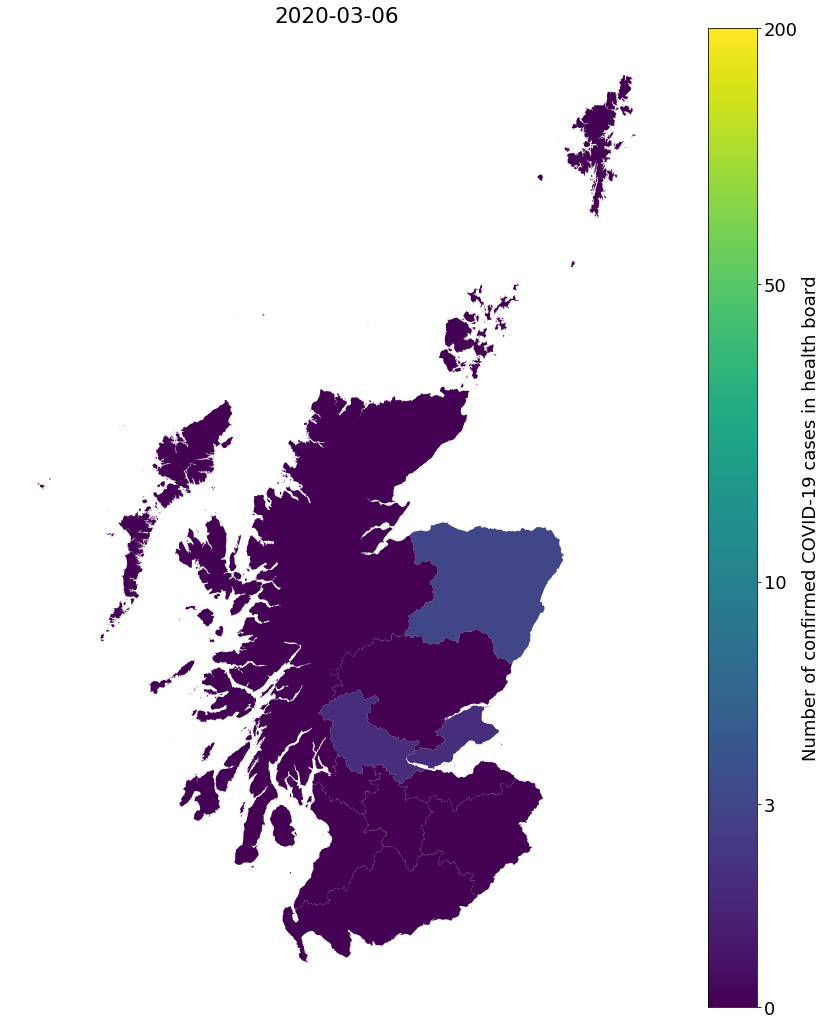

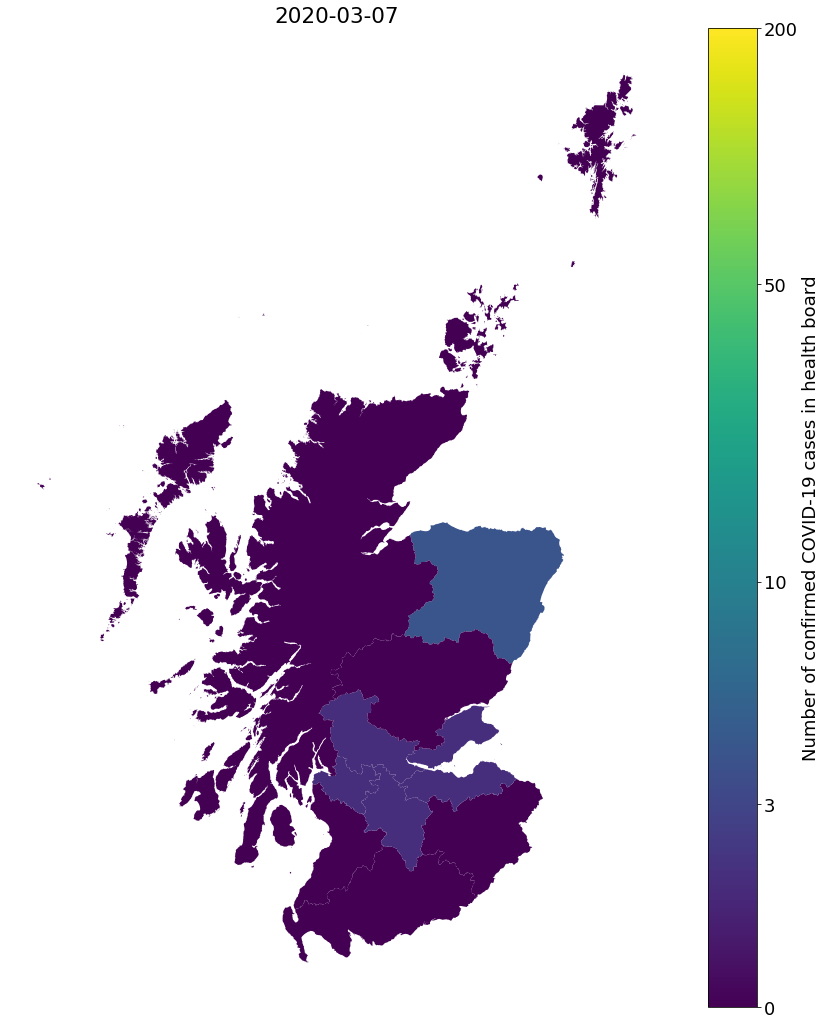

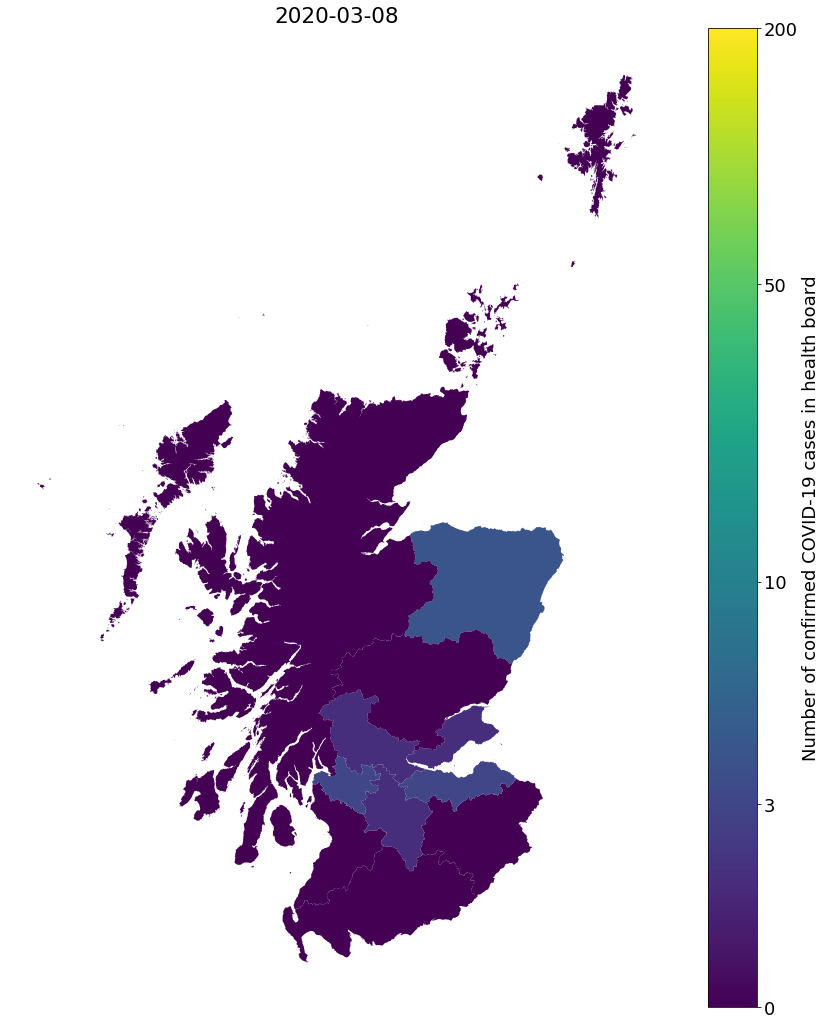

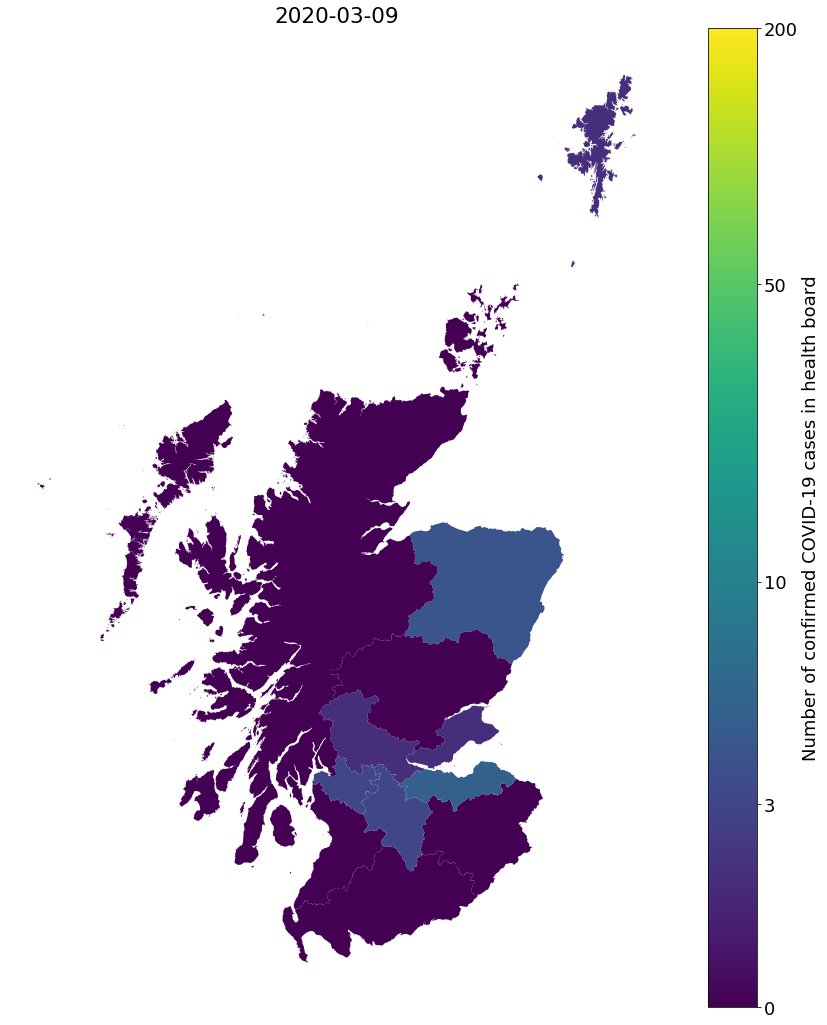

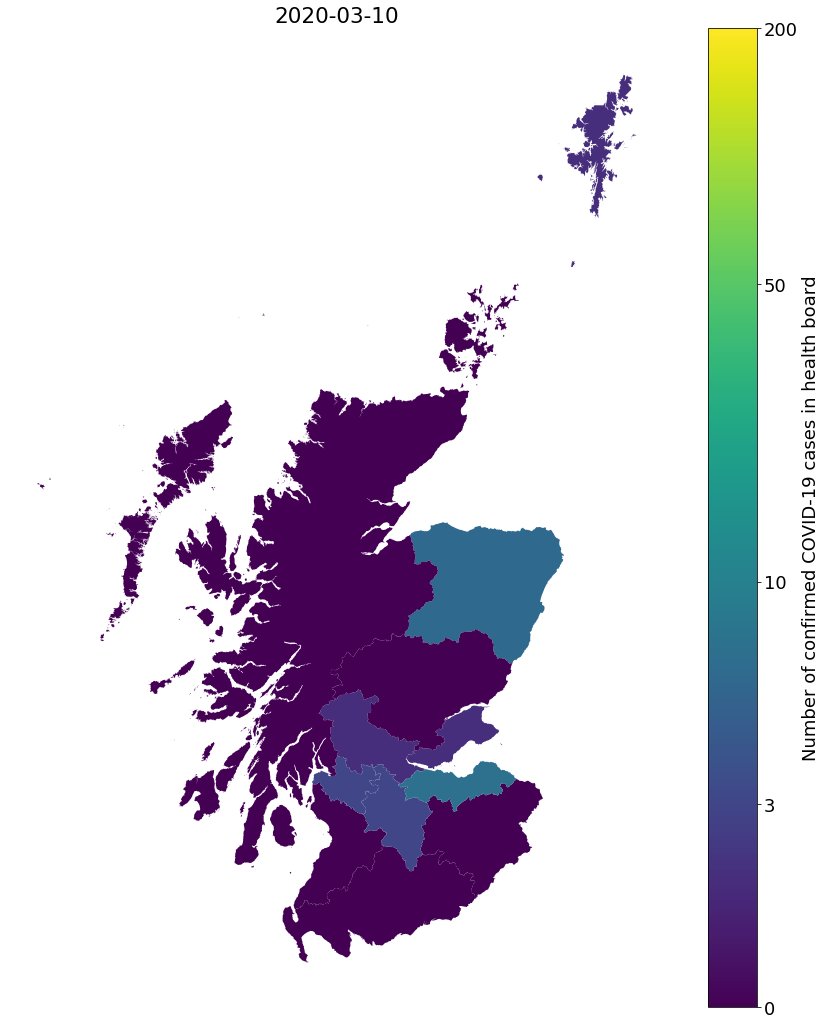

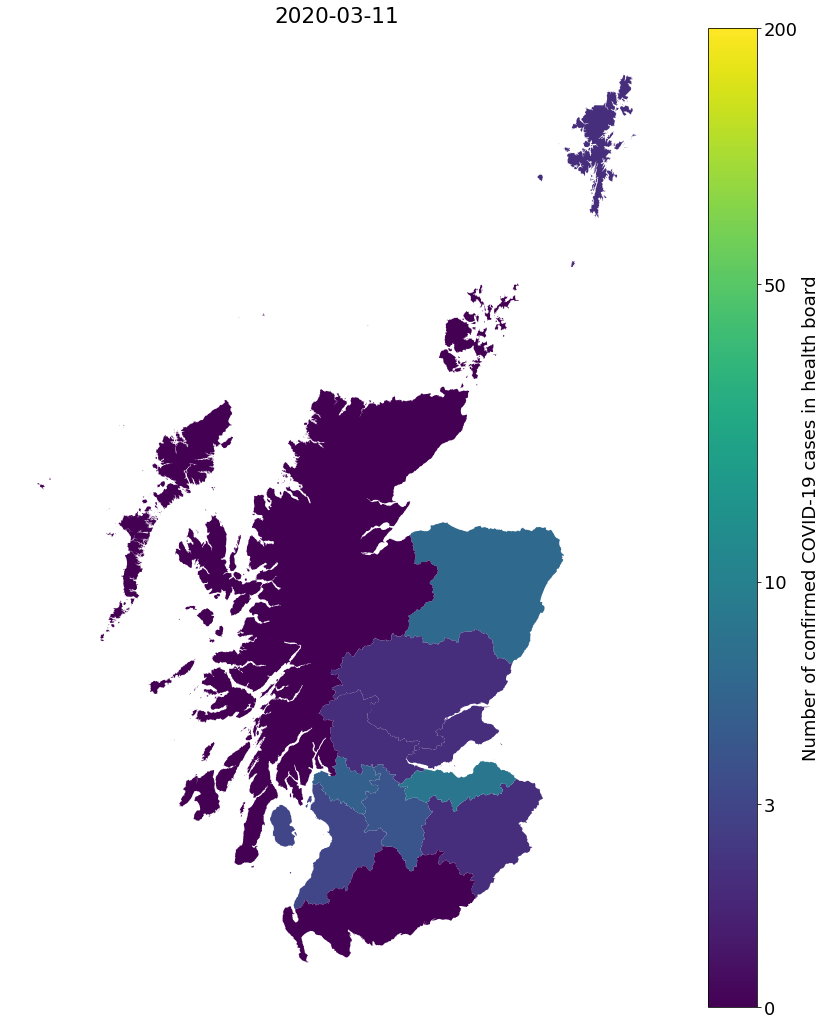

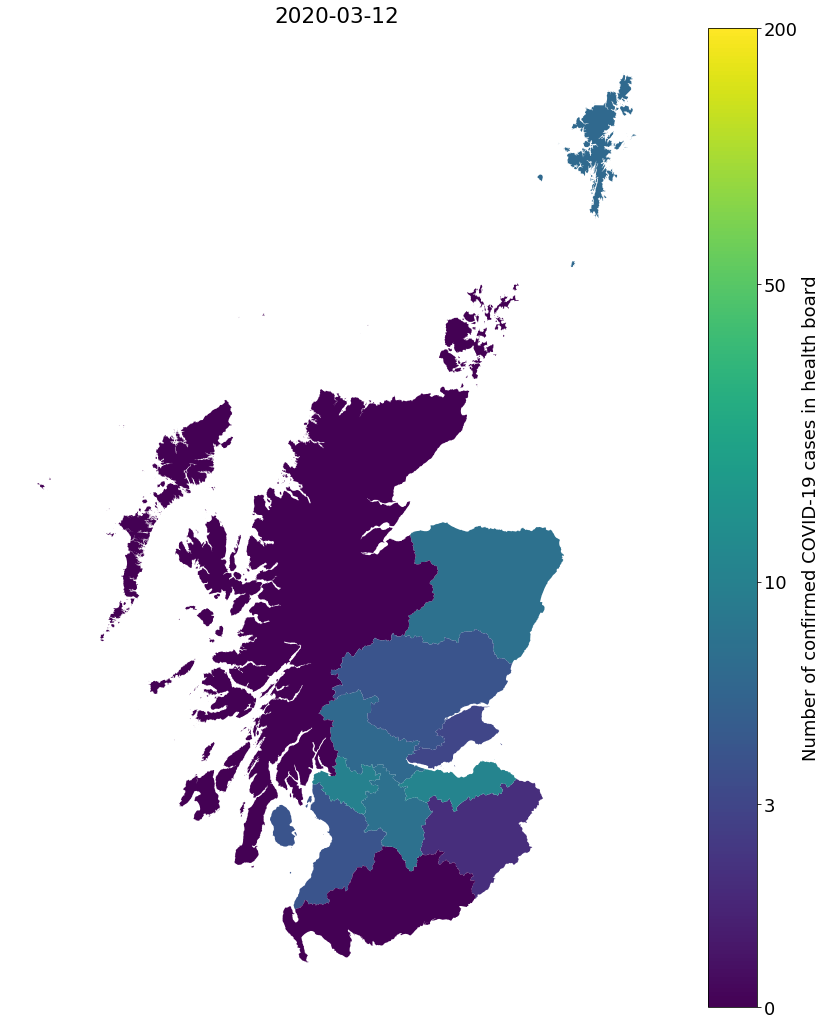

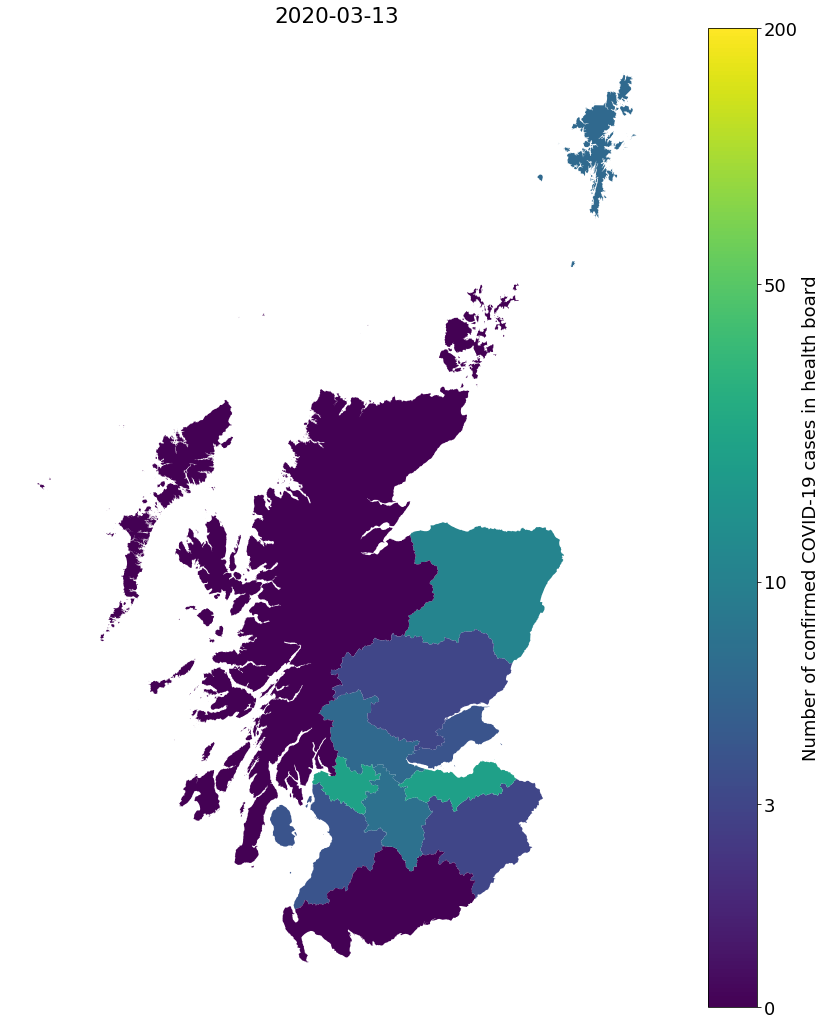

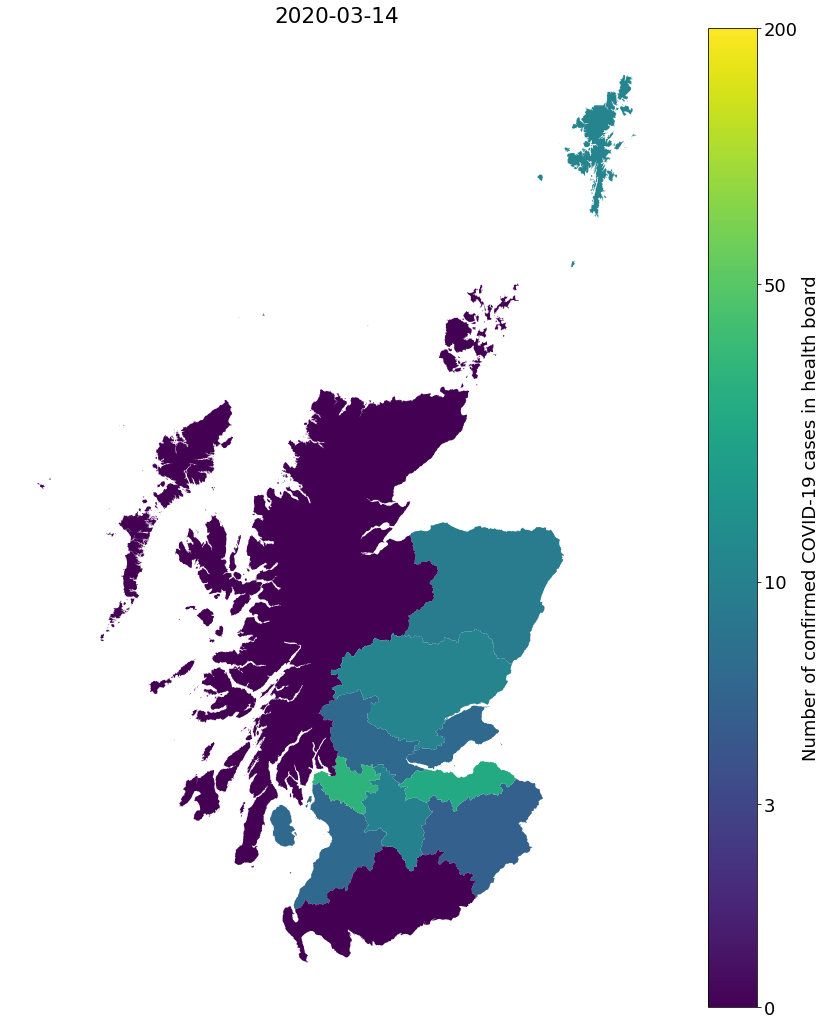

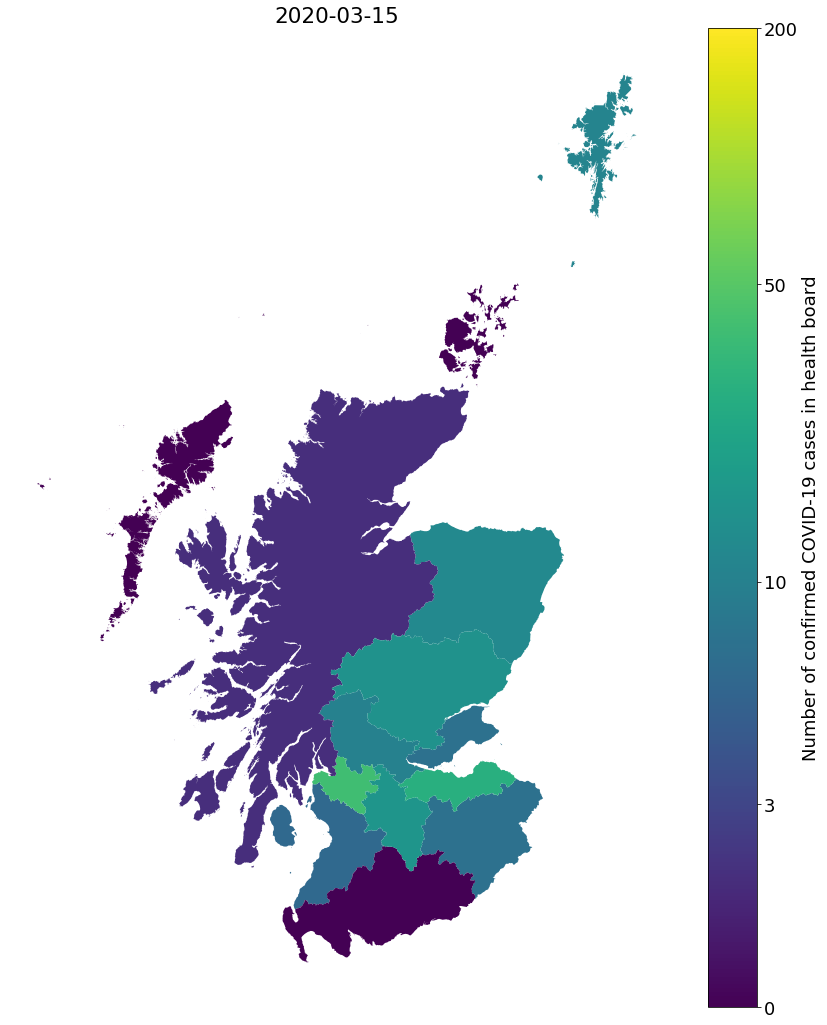

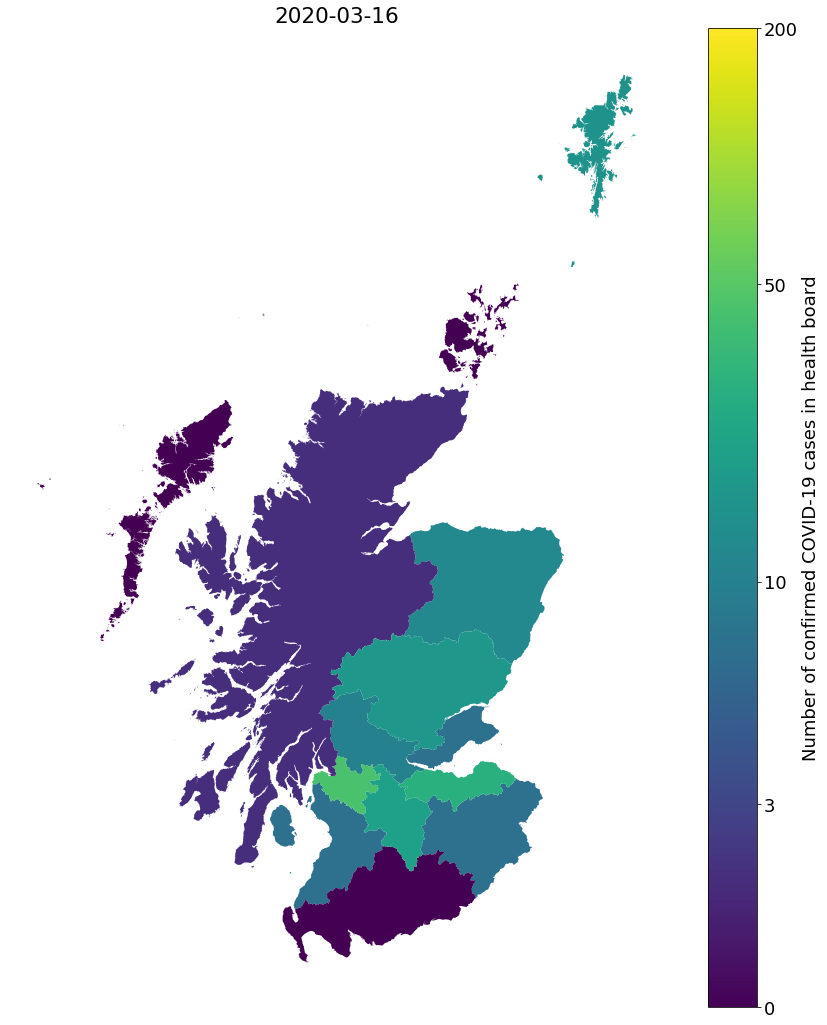

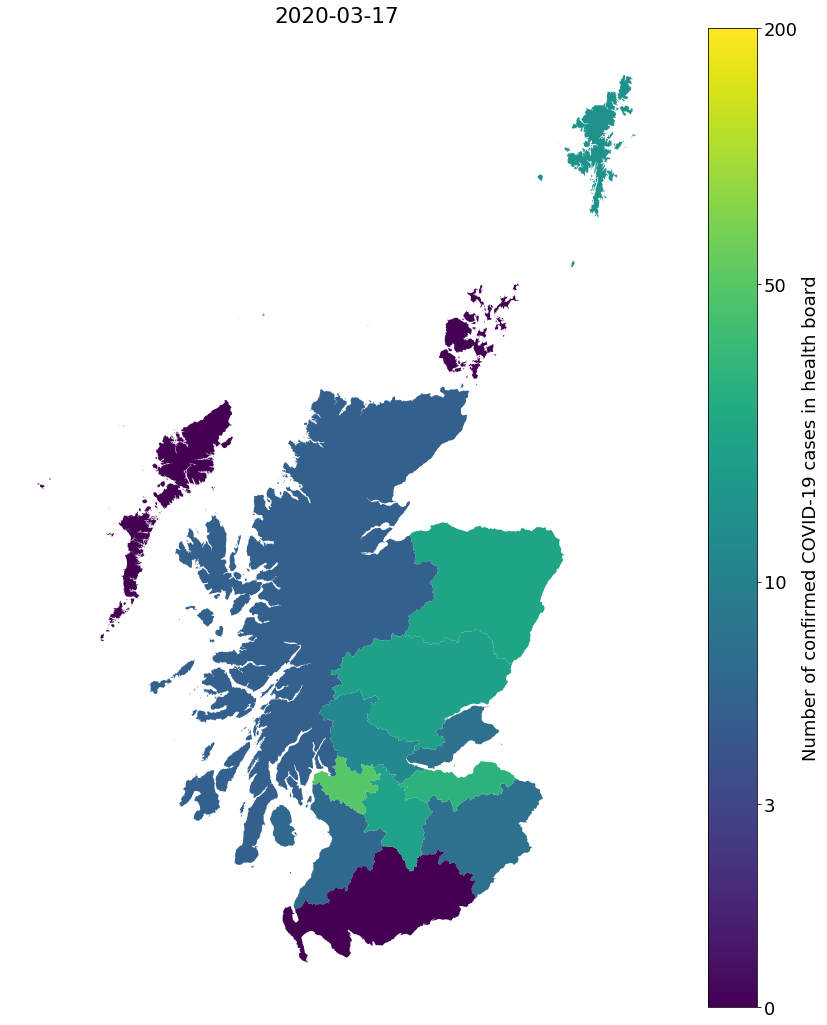

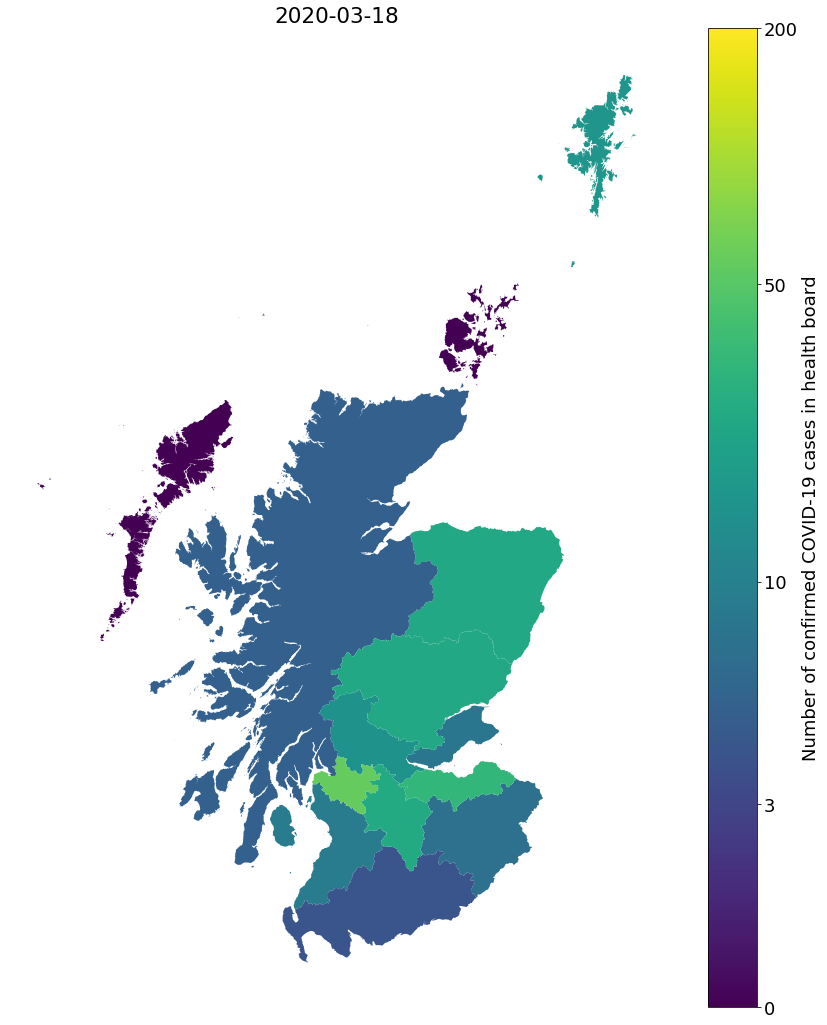

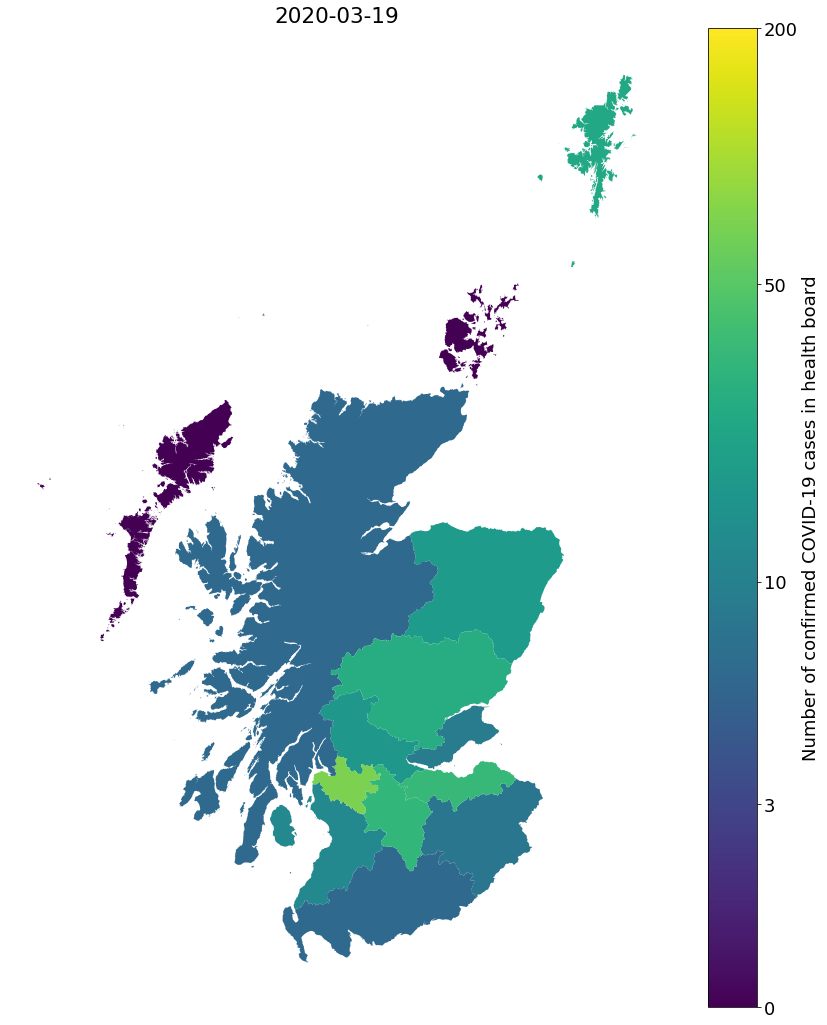

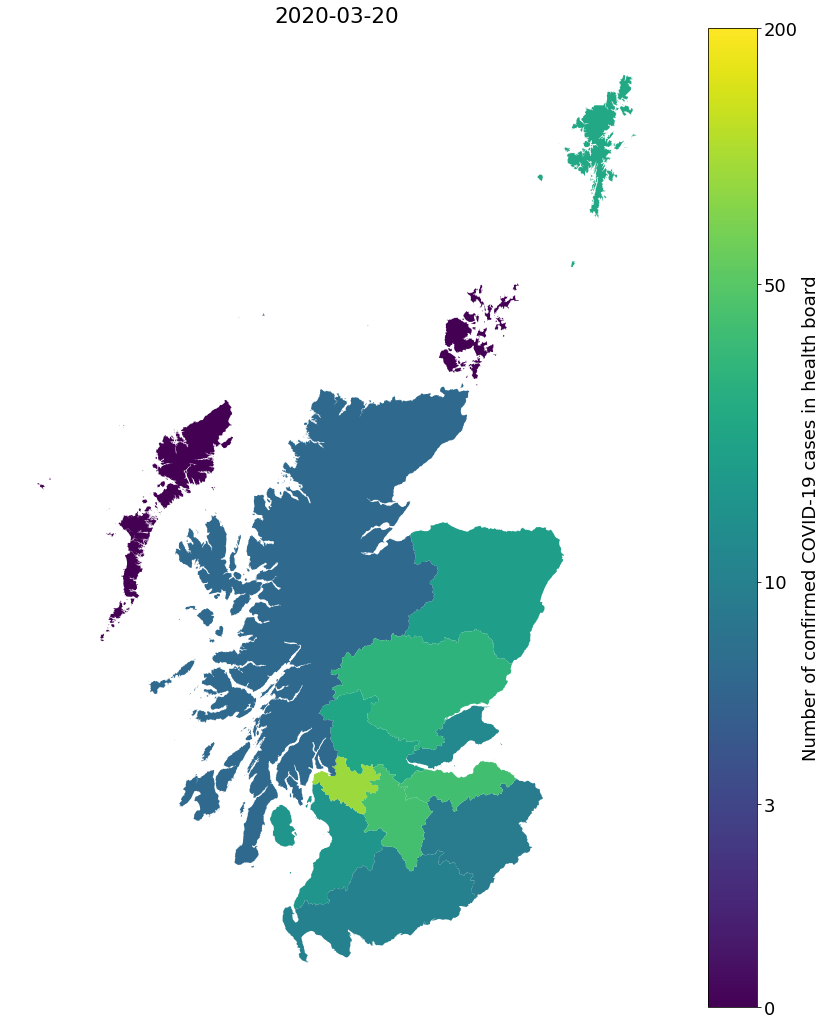

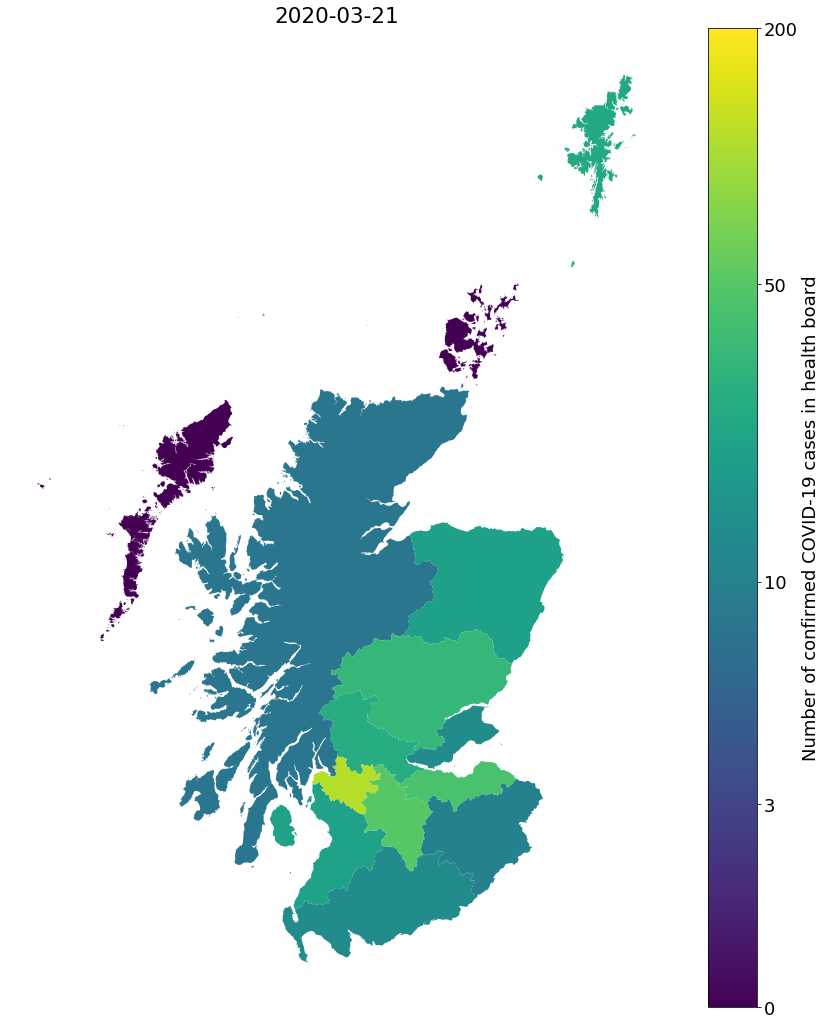

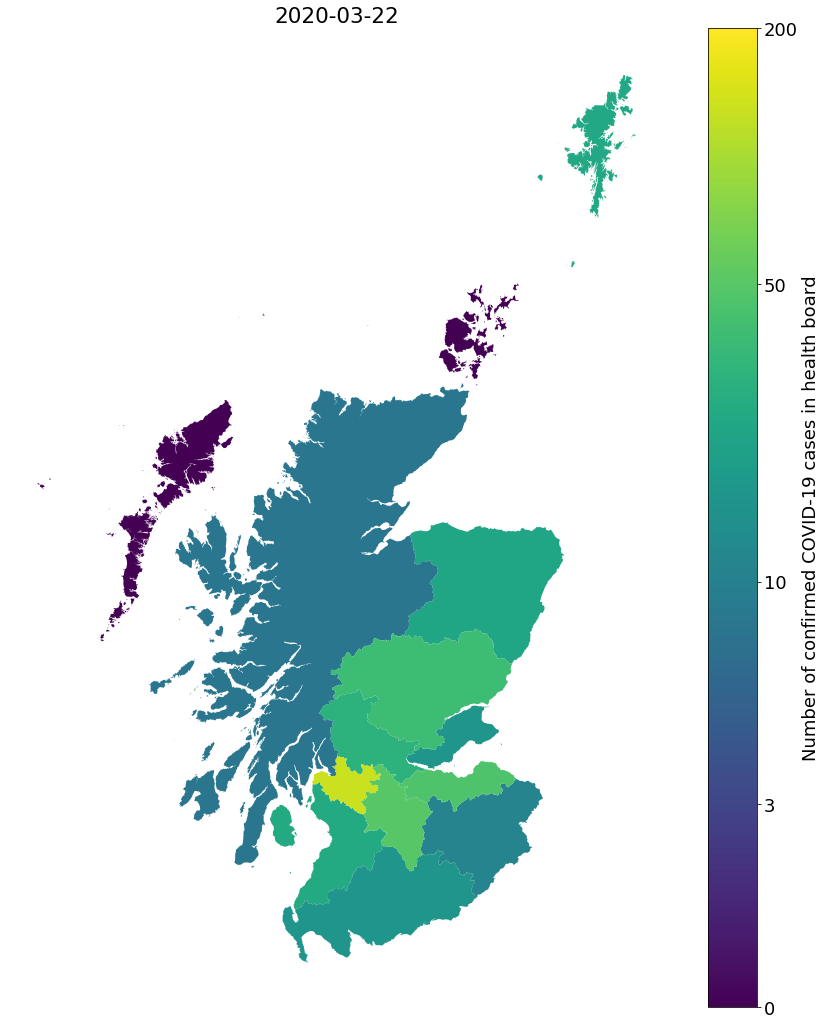

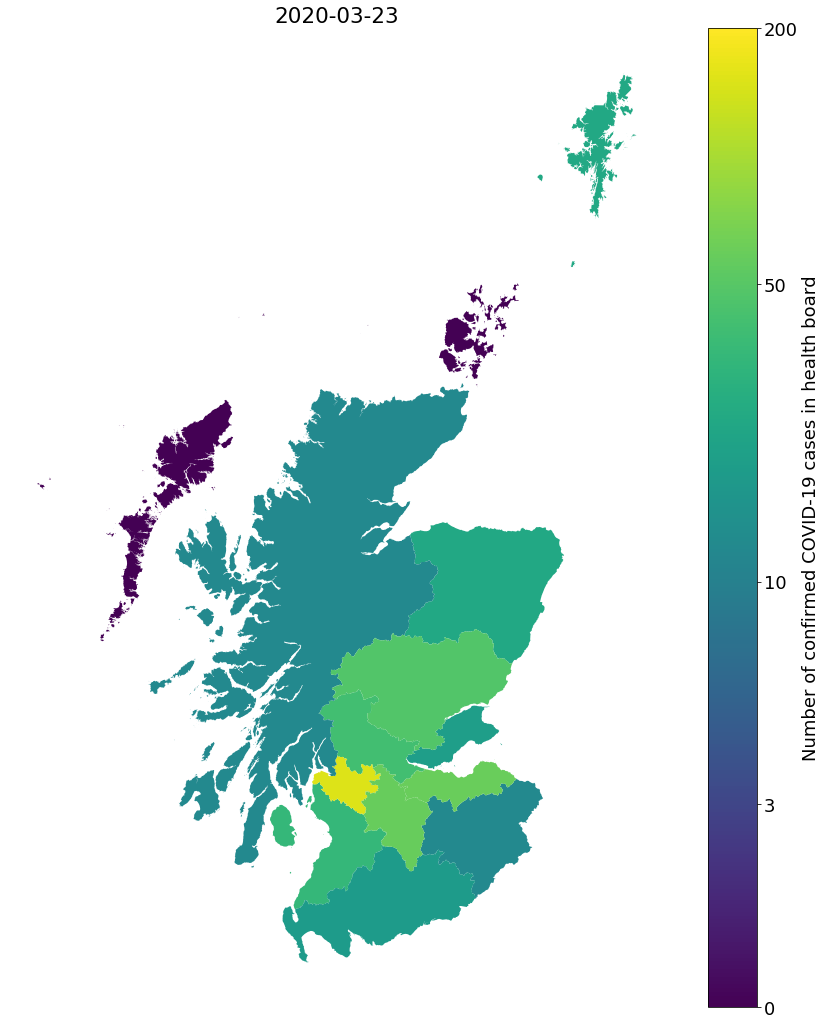

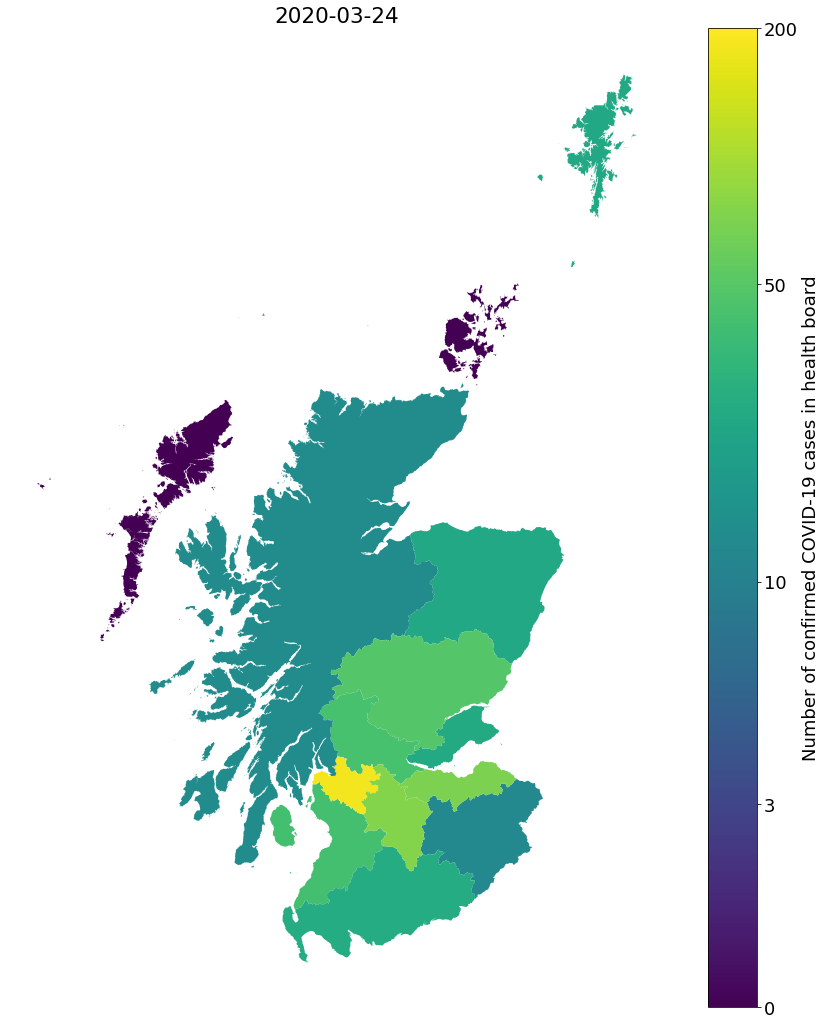

In [323]:
for index, row in results.iterrows():
    output = gpd.GeoDataFrame(row, geometry=health_board_geo_df.geometry).plot(
        column=row.name, vmin=0, vmax=np.log10(200), figsize=figsize)
    output.set_title(str(row.name)[:10])
    output.axis('off')
    cbar = plt.colorbar(output.collections[0])
    cbar.set_ticks([0, np.log10(3), np.log10(10), np.log10(50),np.log10(200)])
    cbar.set_ticklabels(['0', '3', '10', '50','200'])
    cbar.set_label('Number of confirmed COVID-19 cases in health board')
    plt.savefig('output/' + str(row.name)[:10])

In [329]:
os.chdir('output')

In [330]:
!convert -delay 100 -loop 0 2020-03-* time_series.gif

In [ ]:
os.chdir('..')

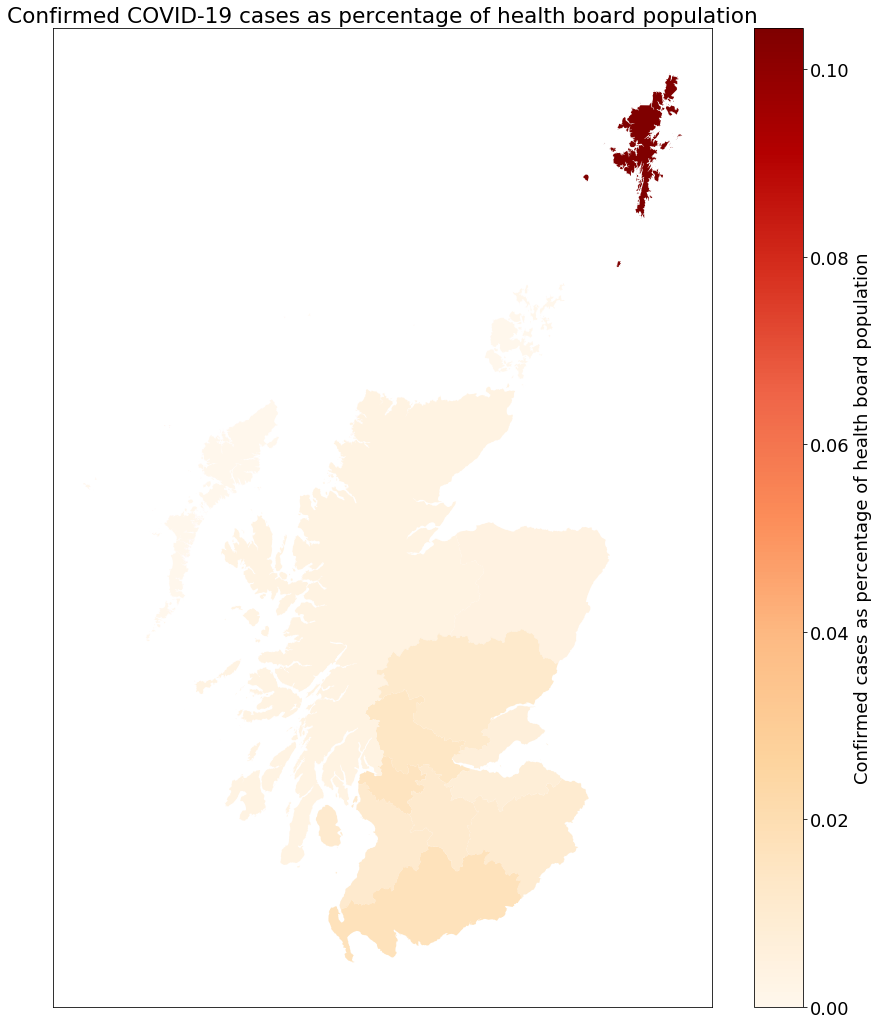

In [171]:
ax = percentage_confirmed_cases_of_health_board_population_geo_df.plot(column=percentage_confirmed_cases_of_health_board_population_geo_df.columns[0], figsize=figsize, legend=True, legend_kwds={'label': "Confirmed cases as percentage of health board population"}, cmap='OrRd')
ax.set_yticks([])
ax.set_xticks([])
plt.title('Confirmed COVID-19 cases as percentage of health board population')
plt.savefig('output/confirmed_cases_as_percentage_of_health_board_population.png')

In [161]:
mean_daily_percent_increase_by_board_geo_df = gpd.GeoDataFrame(mean_daily_percent_increase_by_board, geometry=simplified_health_boards.geometry)

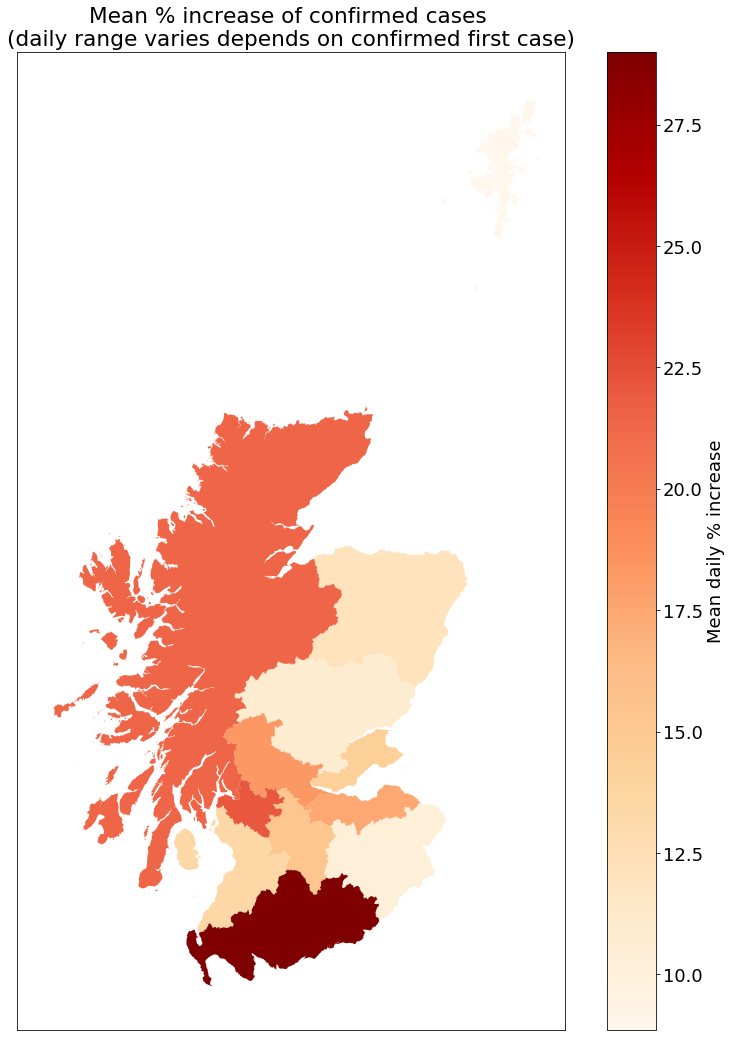

In [172]:
ax = mean_daily_percent_increase_by_board_geo_df.plot(column=mean_daily_percent_increase_by_board_geo_df.columns[0], figsize=(15,18), legend=True, legend_kwds={'label': "Mean daily % increase"}, cmap='OrRd')
ax.set_yticks([])
ax.set_xticks([])
plt.title("Mean % increase of confirmed cases \n(daily range varies depends on confirmed first case)")
plt.savefig('output/mean_percent_increase_by_health_board.png')

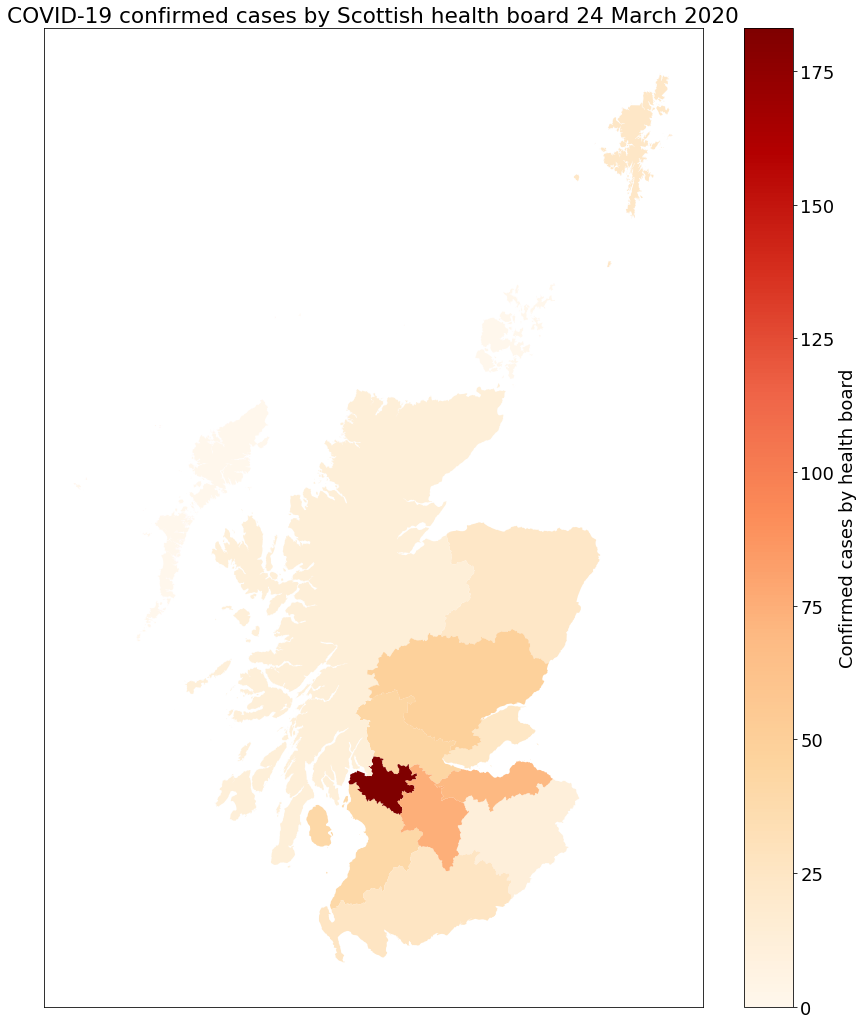

In [173]:
ax = health_board_geo_df.plot(column=health_board_geo_df.columns[0], figsize=(15,18), legend=True, legend_kwds={'label': "Confirmed cases by health board"}, cmap='OrRd')
plt.title('COVID-19 confirmed cases by Scottish health board 24 March 2020')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("output/confirmed_cases_" + str(date) + ".png")

In [102]:
health_board_geo_df.to_file('gis/scottish_health_board_counts_' + date + '.gpkg', driver='GPKG')

## Comparison with wikipedia data

In [ ]:
wiki_data = pd.read_csv('wikipedia_numbers.csv', index_col=0)

In [ ]:
initial_counts = all_results.counts.iloc[0]

In [ ]:
count_difference.sum() + initial_counts

In [ ]:
count_difference = all_results.counts.diff().fillna(0).astype('int')

In [ ]:
wiki_data

In [ ]:
differences = pd.DataFrame(count_difference.values - wiki_data[4:].values, index = count_difference.index, columns=count_difference.columns)

In [ ]:
differences